---
title: Assignment 04
author:
  - name: Bhargavi Manyala
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: today
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
  pdf: 
    embed-resources: true
    toc-depth: 2
    geometry: 
      - landscape
      - margin=0.5in
engine: jupyter
jupyter: assignment-04-kernel
execute:
  echo: true
  eval: true
  output: true
  freeze: auto
---



 # Load the Dataset

In [37]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np


np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")
    .option("escape", "\"")  
    .csv("data/lightcast_job_postings.csv")

)

df.createOrReplaceTempView("job_postings")
#df.show(5)


### Missing Value Treatment

In [38]:
# Missing Value Treatment
from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count, expr, median
from pyspark.sql import functions as F

# Calculate overall median salary
overall_median_salarly = df.approxQuantile("SALARY", [0.5], 0.01)[0]

median_by_employment_type = df.groupBy("EMPLOYMENT_TYPE").agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))
median_by_employment_type_name = df.groupBy("EMPLOYMENT_TYPE_NAME").agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))

# Join median values back to the original dataframe
df_salary_imputed = df.join(median_by_employment_type, on="EMPLOYMENT_TYPE", how = "left").join(median_by_employment_type_name, on="EMPLOYMENT_TYPE_NAME", how = "left")


# Replace missing SALARY values
df_salary_imputed=df_salary_imputed.withColumn("SALARY", when(col("SALARY").isNull(), 
                                when (col("median_salary_emp_type").isNotNull(), col("median_salary_emp_type"))
                                .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
                                .otherwise(overall_median_salarly)
).otherwise(col("SALARY"))) 




# Feature Engineering

### Take columns needed for anlaysis

In [39]:

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import BooleanType, StringType, IntegerType
from pyspark.sql.functions import regexp_replace, trim

# Drop rows with NA values 
regression_df = df_salary_imputed.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME",
    "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING","median_salary_emp_type", "median_salary_emp_type_name"
]).select(
    "SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME",
    "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING","median_salary_emp_type", "median_salary_emp_type_name"
   
)

# Cast Duration to integer
regression_df = regression_df.withColumn("DURATION", col("DURATION").cast(IntegerType()))



### Clean categorical columns 


In [40]:
# Categorical columns
categorical_cols = [ "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"]

# Cast boolean columns to integer
regression_df = regression_df.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast(IntegerType()))
regression_df = regression_df.withColumn("COMPANY_IS_STAFFING", col("COMPANY_IS_STAFFING").cast(IntegerType()))


# Clean Remote Type Name
regression_df = regression_df.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

# Clean Employment Type Name
regression_df = regression_df.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)

# Clean Education Levels
regression_df = regression_df.withColumn(
    "EDUCATION_LEVELS_NAME",
    trim(regexp_replace(col("EDUCATION_LEVELS_NAME"), r"[\[\]\n]", ""))
)


regression_df.show(5, truncate=False)



+--------+--------------------+--------------------+---------------------+--------------------+----------------+--------+-------------+-------------------+----------------------+---------------------------+
|SALARY  |MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|EDUCATION_LEVELS_NAME|EMPLOYMENT_TYPE_NAME|REMOTE_TYPE_NAME|DURATION|IS_INTERNSHIP|COMPANY_IS_STAFFING|median_salary_emp_type|median_salary_emp_type_name|
+--------+--------------------+--------------------+---------------------+--------------------+----------------+--------+-------------+-------------------+----------------------+---------------------------+
|116500.0|2                   |2                   |"Bachelor's degree"  |Fulltime            |Undefined       |6       |0            |0                  |116500                |116500                     |
|116500.0|7                   |7                   |"No Education Listed"|Fulltime            |Undefined       |18      |0            |1                  |116500           

### Final Features Structure

In [41]:
# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

#Assemble base features
assembler = VectorAssembler(inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION"] + [f"{col}_vec" for col in categorical_cols], outputCol="features")


pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data =  pipeline.fit(regression_df).transform(regression_df)
regression_data.select("SALARY","features").show(5, truncate=False)

+--------+-------------------------------------------------------------+
|SALARY  |features                                                     |
+--------+-------------------------------------------------------------+
|116500.0|(28,[0,1,2,3,21,23,26,27],[2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0]) |
|116500.0|(28,[0,1,2,4,21,23,26],[7.0,7.0,18.0,1.0,1.0,1.0,1.0])       |
|116500.0|(28,[0,1,2,4,21,23,26],[1.0,1.0,8.0,1.0,1.0,1.0,1.0])        |
|116500.0|(28,[0,1,2,3,21,23,26,27],[1.0,1.0,32.0,1.0,1.0,1.0,1.0,1.0])|
|131100.0|(28,[0,1,2,3,21,23,26,27],[2.0,2.0,11.0,1.0,1.0,1.0,1.0,1.0])|
+--------+-------------------------------------------------------------+
only showing top 5 rows



# Train/Test Split

In [42]:
# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)

print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

(5039, 22)


(4070, 22)


(969, 22)


# Linear Regression

In [43]:
from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler.getInputCols()

glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",  
    maxIter=10,
    regParam=0.3
)

glr_model = glr.fit(regression_train)
summary = glr_model.summary

### Coefficients and Intercept

In [44]:
# Coefficients and Intercept
print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(glr_model.coefficients):
    print(f"Feature {i + 1}: {coef:.4f}")

Intercept: 86792.4416
Coefficients:
Feature 1: 1611.6790
Feature 2: 1611.6790
Feature 3: 28.5445
Feature 4: 1247.2923
Feature 5: 4395.2943
Feature 6: 9613.9357
Feature 7: -25786.3097
Feature 8: 14121.9136
Feature 9: -10802.3368
Feature 10: -1697.8711
Feature 11: 9148.5650
Feature 12: -12465.7919
Feature 13: 1354.9291
Feature 14: -16520.4012
Feature 15: 33093.9741
Feature 16: -9792.1284
Feature 17: -5104.6945
Feature 18: 3404.4202
Feature 19: 5003.3704
Feature 20: -27508.5111
Feature 21: 2140.9095
Feature 22: 6459.6839
Feature 23: -6724.0609
Feature 24: 3701.7084
Feature 25: 7847.9024
Feature 26: 2132.7803
Feature 27: -2242.5622
Feature 28: -36.7908


### Regression Summary

In [45]:
# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T-Values:", [f"{val:.4f}" for val in summary.tValues])
print("P-Values:", [f"{val:.4f}" for val in summary.pValues])


--- Regression Summary ---


Coefficient Standard Errors: ['25277.8270', '25277.8270', '23.0719', '20920.0566', '20936.4449', '20939.8495', '21079.8038', '21082.5312', '21098.7571', '21110.1720', '21270.4367', '21348.0052', '21575.7584', '21649.7921', '21751.0511', '22067.4219', '22083.8028', '22640.4993', '22402.2783', '25724.6987', '25719.5162', '3159.8576', '3735.1985', '3335.4642', '3406.7472', '3789.8637', '5036.8551', '916.5447', '22025.4149']
T-Values: ['0.0638', '0.0638', '1.2372', '0.0596', '0.2099', '0.4591', '-1.2233', '0.6698', '-0.5120', '-0.0804', '0.4301', '-0.5839', '0.0628', '-0.7631', '1.5215', '-0.4437', '-0.2312', '0.1504', '0.2233', '-1.0693', '0.0832', '2.0443', '-1.8002', '1.1098', '2.3036', '0.5628', '-0.4452', '-0.0401', '3.9406']
P-Values: ['0.9492', '0.9492', '0.2161', '0.9525', '0.8337', '0.6462', '0.2213', '0.5030', '0.6087', '0.9359', '0.6671', '0.5593', '0.9499', '0.4455', '0.1282', '0.6573', '0.8172', '0.8805', '0.8233', '0.2850', '0.9337', '0.0410', '0.0719', '0.2671', '0.0213', '0

### Dispersion Summary

In [46]:
# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")

Null Deviance: 2321265663379.3027
Residual DF Null: 4069
Deviance: 1808610663869.1785
Residual DF: 4041


AIC: 92652.7396


### Tabulate

In [47]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})


coef_table.to_csv("output/glr_summary.csv", index=False)


HTML(coef_table.to_html())

,Feature,Estimate,Std Error,t-stat,P-Value
0,Intercept,86792.4416,25277.8270,0.0638,0.9492
1,MIN_YEARS_EXPERIENCE,1611.6790,25277.8270,0.0638,0.9492
2,MAX_YEARS_EXPERIENCE,1611.6790,23.0719,1.2372,0.2161
3,DURATION,28.5445,20920.0566,0.0596,0.9525
4,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree""",1247.2923,20936.4449,0.2099,0.8337
5,"EDUCATION_LEVELS_NAME_vec_""No Education Listed""",4395.2943,20939.8495,0.4591,0.6462
6,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree""",9613.9357,21079.8038,-1.2233,0.2213
7,"EDUCATION_LEVELS_NAME_vec_""High school or GED"", ""Bachelor's degree""",-25786.3097,21082.5312,0.6698,0.5030
8,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree"", ""Ph.D. or professional degree""",14121.9136,21098.7571,-0.5120,0.6087
9,"EDUCATION_LEVELS_NAME_vec_""High school or GED""",-10802.3368,21110.1720,-0.0804,0.9359


### Linear Regression Interpretation
1. The Generalized Linear Regression (GLR) model achieved an AIC of 92,652.74, demonstrating a moderate fit.
2. Experience variables (MIN_YEARS_EXPERIENCE, MAX_YEARS_EXPERIENCE) have positive coefficients (~+1611), indicating salary increases with experience.
3. Education level plays a key role — "Ph.D. or professional degree" (t = 2.04, p = 0.041) has a significant positive effect on salary.
4. Remote work  also show significant positive impacts on salary.
5. Most other predictors have p-values above 0.05, indicating they are not statistically significant on their own, but when combined, they still help the model capture overall salary patterns.
6. Overall, the model indicates that experience, higher education, remote work flexibility, and company type are the strongest salary drivers, but relatively high AIC suggests factors affecting salary are still not explained.

# Polynomial Regression

In [48]:
# Create squared term for Polynomial Regression
poly_data = regression_data.withColumn(
    "MAX_YEARS_EXPERIENCE_SQ",
    pow(col("MAX_YEARS_EXPERIENCE"), 2)
)

# Assemble polynomial features
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE_SQ", "MAX_YEARS_EXPERIENCE",
        "DURATION"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

poly_data = assembler_poly.transform(poly_data)

poly_data.select("SALARY", "features_poly").show(5, truncate=False)

+--------+------------------------------------------------------------+
|SALARY  |features_poly                                               |
+--------+------------------------------------------------------------+
|117500.0|(29,[0,1,2,3,6,24,27,28],[3.0,9.0,3.0,14.0,1.0,1.0,1.0,1.0])|
|100000.0|(29,[0,1,2,3,4,24,27,28],[3.0,9.0,3.0,42.0,1.0,1.0,1.0,1.0])|
|100000.0|(29,[0,1,2,3,4,24,27,28],[3.0,9.0,3.0,20.0,1.0,1.0,1.0,1.0])|
|100000.0|(29,[0,1,2,3,9,24,27,28],[1.0,1.0,1.0,42.0,1.0,1.0,1.0,1.0])|
|162050.0|(29,[0,1,2,3,5,27,28],[5.0,25.0,5.0,33.0,1.0,1.0,1.0])      |
+--------+------------------------------------------------------------+
only showing top 5 rows



### Split Data

In [49]:

polyreg_train, polyreg_test = poly_data.randomSplit([0.8, 0.2], seed=42)

print((poly_data.count(), len(poly_data.columns)))
print((polyreg_train.count(), len(polyreg_train.columns)))
print((polyreg_test.count(), len(polyreg_test.columns)))

(5039, 24)


(4070, 24)


(969, 24)


In [50]:
from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler.getInputCols()

poly_glr_max_years = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian",   
    link="identity",     
    maxIter=10,         
    regParam=0.3         
)

poly_glr_max_years_model = poly_glr_max_years.fit(poly_data)
poly_summary = poly_glr_max_years_model.summary

### Coefficients and Intercept

In [51]:
print("Intercept: {:.4f}".format(poly_glr_max_years_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_max_years_model.coefficients):
    print(f"Feature {i + 1}: {coef:.4f}")

Intercept: 87729.4985
Coefficients:
Feature 1: 3073.9396
Feature 2: -292.0763
Feature 3: 3073.9396
Feature 4: 29.5828
Feature 5: -2253.9775
Feature 6: 805.2130
Feature 7: 5881.4501
Feature 8: -30439.8972
Feature 9: 8412.8920
Feature 10: -13680.3546
Feature 11: -4660.4367
Feature 12: 7967.9560
Feature 13: -14214.1229
Feature 14: -2857.2642
Feature 15: -15252.4114
Feature 16: 38851.8773
Feature 17: -12908.6915
Feature 18: -9159.5725
Feature 19: 13889.7107
Feature 20: 4123.7347
Feature 21: -40022.9996
Feature 22: 27224.9060
Feature 23: 5759.7671
Feature 24: -6588.6707
Feature 25: 3972.6485
Feature 26: 8353.6157
Feature 27: 2403.5211
Feature 28: -4220.3464
Feature 29: 214.4410


### Ploynomial Summary

In [52]:

print("\n--- Poly Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T-Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P-Values:", [f"{val:.4f}" for val in poly_summary.pValues])


--- Poly Summary ---


Coefficient Standard Errors: ['22747.6805', '36.5365', '22747.6805', '20.5955', '20846.6950', '20859.1237', '20863.3147', '20971.9940', '20987.9155', '20990.0817', '21019.8840', '21100.5976', '21203.5634', '21380.9216', '21419.1586', '21567.5225', '21793.5925', '21905.9591', '22009.1299', '22150.2630', '24166.2009', '24163.3570', '3057.6640', '3566.5832', '2907.7548', '2969.5007', '3355.2443', '4582.4088', '821.4479', '21780.4771']
T-Values: ['0.1351', '-7.9941', '0.1351', '1.4364', '-0.1081', '0.0386', '0.2819', '-1.4515', '0.4008', '-0.6518', '-0.2217', '0.3776', '-0.6704', '-0.1336', '-0.7121', '1.8014', '-0.5923', '-0.4181', '0.6311', '0.1862', '-1.6562', '1.1267', '1.8837', '-1.8473', '1.3662', '2.8131', '0.7163', '-0.9210', '0.2611', '4.0279']
P-Values: ['0.8925', '0.0000', '0.8925', '0.1510', '0.9139', '0.9692', '0.7780', '0.1467', '0.6886', '0.5146', '0.8245', '0.7057', '0.5027', '0.8937', '0.4764', '0.0717', '0.5537', '0.6759', '0.5280', '0.8523', '0.0978', '0.2599', '0.0597',

### Dispersion Summary

In [53]:
# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")

Null Deviance: 2909123659016.3213
Residual DF Null: 5038
Deviance: 2244317022136.5859
Residual DF: 5009


AIC: 114711.0237


### Tabulate

In [54]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

poly_coef_table = pd.DataFrame({
    "Feature": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in poly_tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in poly_pvals]
})


poly_coef_table.to_csv("output/poly_summary.csv", index=False)


HTML(poly_coef_table.to_html())

,Feature,Estimate,Std Error,t-stat,P-Value
0,Intercept,87729.4985,22747.6805,0.1351,0.8925
1,MIN_YEARS_EXPERIENCE,3073.9396,36.5365,-7.9941,0.0000
2,MAX_YEARS_EXPERIENCE_SQ,-292.0763,22747.6805,0.1351,0.8925
3,MAX_YEARS_EXPERIENCE,3073.9396,20.5955,1.4364,0.1510
4,DURATION,29.5828,20846.6950,-0.1081,0.9139
5,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree""",-2253.9775,20859.1237,0.0386,0.9692
6,"EDUCATION_LEVELS_NAME_vec_""No Education Listed""",805.2130,20863.3147,0.2819,0.7780
7,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree""",5881.4501,20971.9940,-1.4515,0.1467
8,"EDUCATION_LEVELS_NAME_vec_""High school or GED"", ""Bachelor's degree""",-30439.8972,20987.9155,0.4008,0.6886
9,"EDUCATION_LEVELS_NAME_vec_""Bachelor's degree"", ""Master's degree"", ""Ph.D. or professional degree""",8412.8920,20990.0817,-0.6518,0.5146


### Polynomial Regression Interpretation
1. The Polynomial model (AIC = 114,711.02) does not perform well statistically, but it helps to show how salary growth changes with experience, for example, salaries increase quickly at first and then level off at higher experience levels.
2. Experience is the strongest factor (t = −7.99, p < 0.001), showing that salaries increase with experience but slow down at higher levels.
3. Company type (t = 4.03, p < 0.001) and remote work flexibility (t = 2.81, p = 0.0049) also have a significant positive effect on salary, while higher education (t = 1.88, p ≈ 0.06) adds a moderate impact.
4. Most other predictors are not individually significant but together help improve model performance.
5. Overall, experience, company type, remote work, and education are the main factors influencing salary.

# Random Forest Regressor

In [55]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="SALARY",
    numTrees=300,
    maxDepth=6,
    subsamplingRate=0.8,
    featureSubsetStrategy="auto",
    seed=42
)

rf_model = rf.fit(regression_train)
rf_pred = rf_model.transform(regression_test)

evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(rf_pred)
r2 = evaluator_r2.evaluate(rf_pred)
mae = evaluator_mae.evaluate(rf_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² (Coefficient of Determination): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

25/10/08 03:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1645.3 KiB
25/10/08 03:33:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Root Mean Squared Error (RMSE): 21266.70
R² (Coefficient of Determination): 0.25
Mean Absolute Error (MAE): 14848.19


### Feature Importance Plot

/tmp/ipykernel_1651/2256788607.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




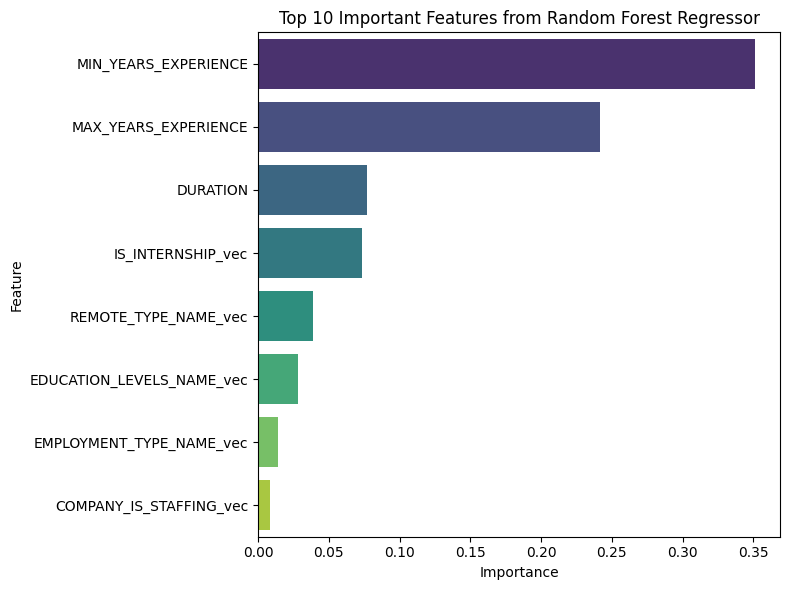

,Feature,Importance
0,MIN_YEARS_EXPERIENCE,0.351221
1,MAX_YEARS_EXPERIENCE,0.241951
2,DURATION,0.076753
6,IS_INTERNSHIP_vec,0.073518
5,REMOTE_TYPE_NAME_vec,0.039052
3,EDUCATION_LEVELS_NAME_vec,0.028002
4,EMPLOYMENT_TYPE_NAME_vec,0.014275
7,COMPANY_IS_STAFFING_vec,0.008182


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


importances = rf_model.featureImportances.toArray()

feature_names = assembler.getInputCols()

# Match lengths safely 
min_len = min(len(importances), len(feature_names))
feature_names = feature_names[:min_len]
importances = importances[:min_len]


fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top10_fi = fi_df.head(10)


plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=top10_fi, palette="viridis")
plt.title("Top 10 Important Features from Random Forest Regressor")
plt.tight_layout()

plt.savefig("output/rf_feature_importance.png", dpi=300)
plt.show()
top10_fi

### Random Forest Interpretation
1. The Random Forest model achieved an R² of 0.25, explaining about 25% of the salary variation, which indicates moderate predictive accuracy.
2. With an RMSE of 21,266.70 and MAE of 14,848.19, the model demonstrates reasonable performance.
3. Experience is the most significant factor affecting salary, followed by job duration, internship status, and remote work type.
4. Overall, the Random Forest model effectively captures non-linear relationships and provides a balanced prediction of salaries.

# Compare 3 Models – GLR, Polynomial, RF


Model Performance Comparison:
                     Model       RMSE        MAE     R²         AIC        BIC
0  GLR (Linear Regression)  22030.884  15515.171  0.194   92652.740  19435.399
1    Polynomial Regression  21636.911  15137.690  0.222  114711.024  19407.305
2  Random Forest Regressor  21266.702  14848.191  0.249         NaN  19366.982


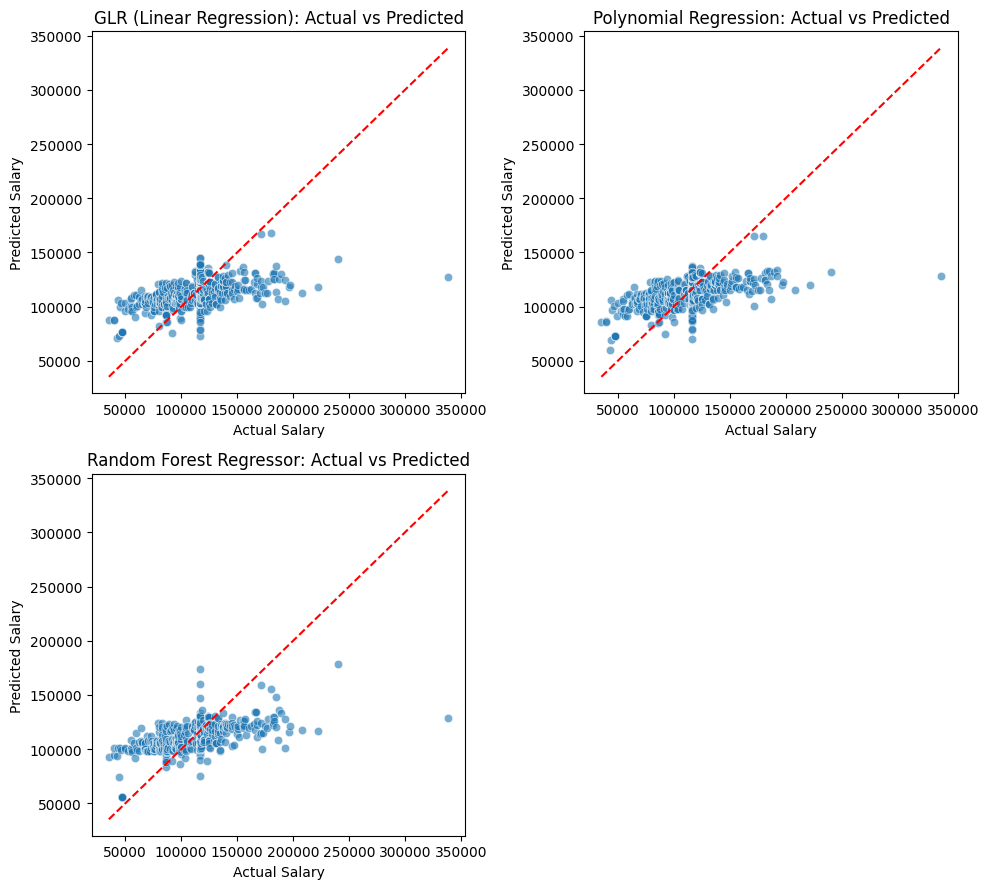

In [57]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator

pred_glr = glr_model.transform(regression_test).select("SALARY", "prediction").toPandas()
pred_poly = poly_glr_max_years_model.transform(polyreg_test).select("SALARY", "prediction").toPandas()
pred_rf = rf_model.transform(regression_test).select("SALARY", "prediction").toPandas()

pred_glr.rename(columns={"prediction": "Predicted"}, inplace=True)
pred_poly.rename(columns={"prediction": "Predicted"}, inplace=True)
pred_rf.rename(columns={"prediction": "Predicted"}, inplace=True)

evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")

rmse_glr = evaluator_rmse.evaluate(glr_model.transform(regression_test))
rmse_poly = evaluator_rmse.evaluate(poly_glr_max_years_model.transform(polyreg_test))
rmse_rf = evaluator_rmse.evaluate(rf_model.transform(regression_test))

mae_glr = evaluator_mae.evaluate(glr_model.transform(regression_test))
mae_poly = evaluator_mae.evaluate(poly_glr_max_years_model.transform(polyreg_test))
mae_rf = evaluator_mae.evaluate(rf_model.transform(regression_test))

r2_glr = evaluator_r2.evaluate(glr_model.transform(regression_test))
r2_poly = evaluator_r2.evaluate(poly_glr_max_years_model.transform(polyreg_test))
r2_rf = evaluator_r2.evaluate(rf_model.transform(regression_test))

aic_glr = glr_model.summary.aic
aic_poly = poly_glr_max_years_model.summary.aic

n_glr = regression_test.count()
n_poly = polyreg_test.count()
n_rf = regression_test.count()

k_glr = len(assembler.getInputCols())
k_poly = len(assembler_poly.getInputCols())
k_rf = len(assembler.getInputCols())

bic_glr = n_glr * math.log(rmse_glr**2) + k_glr * math.log(n_glr)
bic_poly = n_poly * math.log(rmse_poly**2) + k_poly * math.log(n_poly)
bic_rf = n_rf * math.log(rmse_rf**2) + k_rf * math.log(n_rf)

results_df = pd.DataFrame({
    "Model": ["GLR (Linear Regression)", "Polynomial Regression", "Random Forest Regressor"],
    "RMSE": [rmse_glr, rmse_poly, rmse_rf],
    "MAE": [mae_glr, mae_poly, mae_rf],
    "R²": [r2_glr, r2_poly, r2_rf],
    "AIC": [aic_glr, aic_poly, np.nan],
    "BIC": [bic_glr, bic_poly, bic_rf]
})

print("\nModel Performance Comparison:")
print(results_df.round(3))

plt.figure(figsize=(10, 9))
positions = [1, 2, 3]
names = ["GLR (Linear Regression)", "Polynomial Regression", "Random Forest Regressor"]
dataframes = [pred_glr, pred_poly, pred_rf]

for pos, (name, df) in zip(positions, zip(names, dataframes)):
    plt.subplot(2, 2, pos)
    sns.scatterplot(x="SALARY", y="Predicted", data=df, alpha=0.6)
    plt.plot(
        [df["SALARY"].min(), df["SALARY"].max()],
        [df["SALARY"].min(), df["SALARY"].max()],
        color="red", linestyle="--"
    )
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.title(f"{name}: Actual vs Predicted")

plt.tight_layout()
plt.show()


### Comparision Interpretation
1. Random Forest Regressor performed the best overall, achieving the lowest RMSE (21,266.70) and MAE (14,848.19), along with the highest R² (0.25), meaning it explains about 25% of the salary variation. 
2. Overall, this indicates that Random Forest captures non-linear relationships more effectively compared to other models.

### Calculating Log-Likelihood and BIC for PySpark Models

In [59]:
import math

def calculate_loglik_bic(summary, n, k):
    dispersion = float(summary.dispersion)
    deviance = float(summary.deviance)
    
    log_likelihood = -0.5 * (
        n * math.log(2 * math.pi) +
        n * math.log(dispersion) +
        (deviance / dispersion)
    )
    bic = k * math.log(n) - 2 * log_likelihood
    return log_likelihood, bic

# GLR Model
n_glr = regression_train.count()
k_glr = len(assembler.getInputCols()) + 1
logL_glr, bic_glr_ll = calculate_loglik_bic(glr_model.summary, n_glr, k_glr)

# Polynomial Model
n_poly = polyreg_train.count()
k_poly = len(assembler_poly.getInputCols()) + 1
logL_poly, bic_poly_ll = calculate_loglik_bic(poly_glr_max_years_model.summary, n_poly, k_poly)


print(f"GLR Log-Likelihood: {logL_glr:.2f}")
print(f"GLR BIC: {bic_glr_ll:.2f}\n")

print(f"Polynomial Log-Likelihood: {logL_poly:.2f}")
print(f"Polynomial BIC: {bic_poly_ll:.2f}")


GLR Log-Likelihood: -46296.42
GLR BIC: 92667.65

Polynomial Log-Likelihood: -46782.66
Polynomial BIC: 93648.43


###  Log-Likelihood and BIC Interpretation
1. The Linear Regression (GLR) model fits the salary data better, with a higher Log-Likelihood (−46,296.42) and a lower BIC (92,667.65) compared to the Polynomial model (−46,782.66).
2. Overall, the GLR model is simpler and more efficient.